# COVID Spark Protein Alignment

In [6]:
!pip install biopython
!pip install ipytree
!wget https://mafft.cbrc.jp/alignment/software/mafft_7.471-1_amd64.deb
!sudo dpkg -i mafft_7.471-1_amd64.deb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-01-09 14:07:17--  https://mafft.cbrc.jp/alignment/software/mafft_7.471-1_amd64.deb
Resolving mafft.cbrc.jp (mafft.cbrc.jp)... 133.1.49.95
Connecting to mafft.cbrc.jp (mafft.cbrc.jp)|133.1.49.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3635234 (3.5M)
Saving to: ‘mafft_7.471-1_amd64.deb’

mafft_7.471-1_amd64 100%[===================>]   3.47M  2.80MB/s    in 1.2s    

2023-01-09 14:07:19 (2.80 MB/s) - ‘mafft_7.471-1_amd64.deb’ saved [3635234/3635234]

Selecting previously unselected package mafft.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack mafft_7.471-1_amd64.deb ...
Unpacking mafft (7.471-1) ...
Setting up mafft (7.471-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has a crown-like appearance due to the S surface glycoprotein on the outside of the virus particle. The S protein mediates the attachment of the virus particle to the host cell, which necessitates the protein to be studied for vaccine development, antibody therapies, and antigen-based diagnostic tests. In this notebook, I will be performing multiple protein alignment on different variants of the virus. 

In [2]:
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")
DATA = Path("/content/drive/My Drive/Colab Notebooks/Genomics Projects")

Mounted at /content/drive


## Multiple Sequence Alignment and Phylogenetic Tree

The following set of sequence ids have been selected for this analysis. All spike protein sequences that have been submitted to NCBI can be downloaded at NCBI Datasets website. `YP_009724390.1` is the reference sequence.



In [1]:
seq_id_of_interest = [
    'QRN78347.1',
    'QRX39425.1',
    'QUD52764.1',
    'QWE88920.1',
    'UFO69279.1',
    'UOZ45804.1',
    'UTM82166.1',
    'YP_009724390.1',
]

The above sequences can be fetched from NCBI directly and saved to a fasta file.

In [4]:
from Bio import Entrez

Entrez.email = "ss6631@columbia.edu"
seq_id = ",".join(seq_id_of_interest)
handle = Entrez.efetch(db="protein", id=seq_id, rettype="fasta")
fasta_file = "cov_protein_seqs.fasta"
with open(fasta_file, "w") as fo:
    fo.write(handle.read())

In [11]:
!cat cov_protein_seqs.fasta

>QRN78347.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2]
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHV
SGTNGTKRFANPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPF
LGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPI
NLVRGLPQGFSALEPLVDLPIGINITRFQTLHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENG
TITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAW
NRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNY
KLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQ
SYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQ
QFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTW
RVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGVEN
SVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE
QDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGD
IAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNG

In [13]:
from Bio import AlignIO
align = AlignIO.read(aln_file, "fasta")
print(align)

Alignment with 8 rows and 1275 columns
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QRN78347.1
MFVFLVLLPLVSSQCVNFTNRTQLPSAYTNSFTRGVYYPDKVFR...HYT QRX39425.1
MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QUD52764.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QWE88920.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT UFO69279.1
MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFR...HYT UOZ45804.1
MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFR...HYT UTM82166.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT YP_009724390.1


I am using `MAFFT` to perform multiple sequence alignment on S protein sequences. `biopython` commandline wrapper called `MafftCommandline` can be found under `Bio.Align.Applications` and it can be used to easily run the alignment. 

In [7]:
from Bio.Align.Applications import MafftCommandline

aln_file = "align_cov_protein_seqs.fasta"
mafft_cline = MafftCommandline(input=fasta_file)
stdout, stderr = mafft_cline()
with open(aln_file, "w") as handle:
    handle.write(stdout)

from Bio import AlignIO
align = AlignIO.read(aln_file, "fasta")

In [12]:
!cat align_cov_protein_seqs.fasta

>QRN78347.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2]
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFANPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINL--VRGLPQGFSALEPLVDLPIGINITRF
QT---LHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSE
TKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRI
SNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNI
ADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGST
PCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKC
VNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVI
TPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNN
SYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGVENSVAYSNNSIAIPTNF
TISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNT
QEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYG
DCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPF
AM

Once the alignment is completed, we can construct a phylogenetic tree to visualize the genomic evolutions of different virus variants. First, I used `DistanceCalculator` to generate the distance matrix. I set the `model` parameter to `blosum62` since `MAFFT` uses `blosum62` as the scoring matrix by default. 

In [8]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

calculator = DistanceCalculator('blosum62')
dm = calculator.get_distance(align)

Then, the phylogenetic tree can be constructed using the UPGMA method, which is done through the `DistanceTreeConstructor` class. 

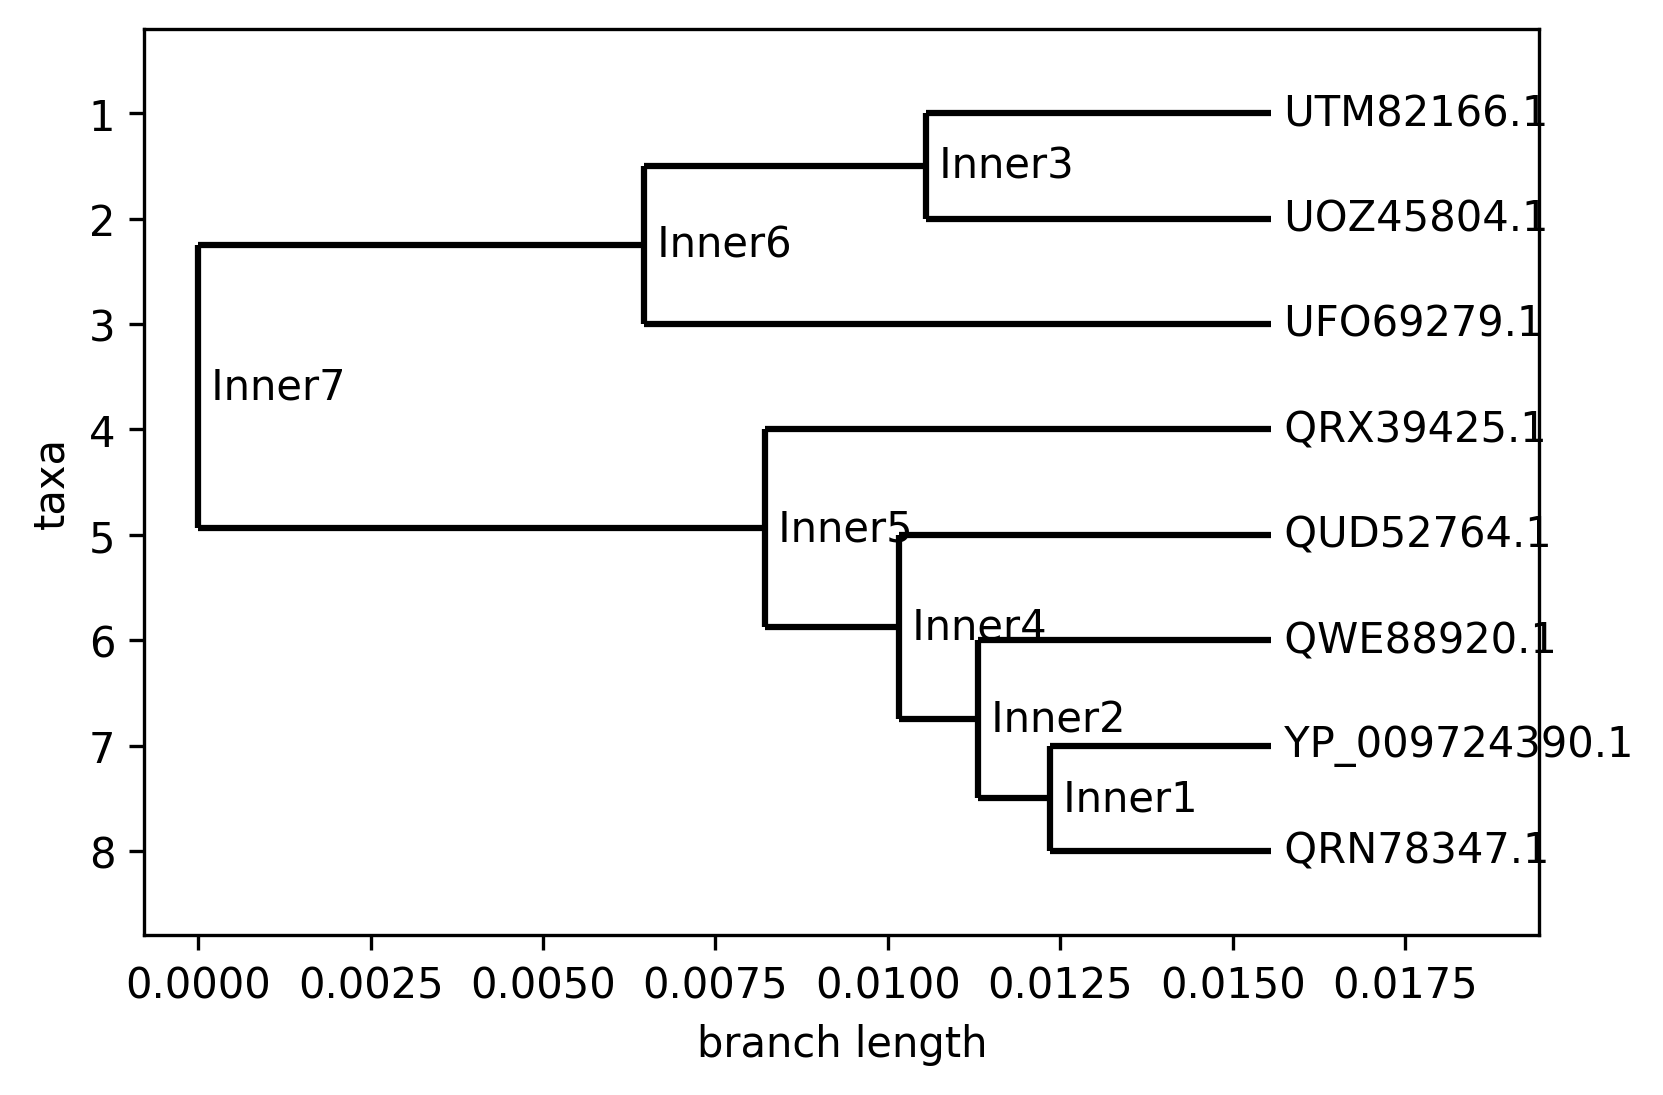

In [9]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import matplotlib.pyplot as plt
from Bio import Phylo

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

virus_subtype_mapping = {
    "QRN78347.1": "QRN78347.1",
    "QRX39425.1": "QRX39425.1",
    "QUD52764.1": "QUD52764.1",
    "QWE88920.1": "QWE88920.1",
    "UFO69279.1": "UFO69279.1",
    "UOZ45804.1": "UOZ45804.1",
    "UTM82166.1": "UTM82166.1",
    "YP_009724390.1": "YP_009724390.1",
}

fig, ax = plt.subplots(dpi=300)
Phylo.draw(tree, axes=ax,
           label_func=lambda n: virus_subtype_mapping[str(n)]
                                if str(n) in virus_subtype_mapping else str(n))

From the phylogenetic tree, we can observe two main clusters if we set the branch length cutoff to 0.005.

## Identifying different disease variants

Using the reference sequence and the alignment that I have just created, I can identify all mutations in spike proteins of the other 7 sequences. The three variants of COVID (alpha, delta, omicron) can be assigned based on the signature given in the following plot by Viralzon.

![](https://viralzone.expasy.org/resources/Variants_graph.svg)

In [10]:
import pandas as pd

aln = AlignIO.read(open(aln_file), 'fasta')
align_df = pd.DataFrame(dict([(virus_subtype_mapping[rec.name], list(rec.seq))
                              for rec in aln]))

aa_index = (align_df["YP_009724390.1"] != "-").cumsum()
aa_count = align_df.apply(lambda row: row.nunique(), axis=1)

align_df["aa_index"] = aa_index
align_df[945:960]

,QRN78347.1,QRX39425.1,QUD52764.1,QWE88920.1,UFO69279.1,UOZ45804.1,UTM82166.1,YP_009724390.1,aa_index
945,A,A,A,A,A,A,A,A,944
946,L,L,L,L,L,L,L,L,945
947,G,G,G,G,G,G,G,G,946
948,K,K,K,K,K,K,K,K,947
949,L,L,L,L,L,L,L,L,948
950,Q,Q,Q,Q,Q,Q,Q,Q,949
951,D,D,N,D,D,D,D,D,950
952,V,V,V,V,V,V,V,V,951
953,V,V,V,V,V,V,V,V,952
954,N,N,N,N,N,N,N,N,953


The above table shows rows 945-959 of the alignment corresponding to 945-959th bases of the sequence. One distinctive mutation in the delta variant is D950N, which means that at position 950, a D is switched out with an N. Not just one, but multiple positions must be examined to conclude the identity of a variant, and after careful examination of other mutations, `QUD52764.1` can be identified as the delta variant. Similarly, other sequences can be identified as follows:

- QRN78347.1: Beta (D80A, D215G, N501Y...)
- QRX39425.1: Gamma (T20N, R190S, N501Y...)
- QUD52764.1: Delta (T478K, D950N...)
- QWE88920.1: Alpha (del144, N501Y, A570D...)
- UFO69279.1: Omicron (S477N, T478K, E484A, N501Y, Y505H...)
- UOZ45804.1: Omicron (S477N, T478K, E484A, N501Y, Y505H...)
- UTM82166.1: Omicron (S477N, T478K, E484A, N501Y, Y505H...)